# Starting point: plain Tamura surface fluxes
The starting point is defined by the raw Tamura 2008 daily surface net heat and surface freshwater fluxes and daily surface stresses derived from EraInterim winds. The surface heat fluxes in summer has been reduced to half during the forcing file generation, what has been shown necessary in previous applications.

In [3]:
#import bunch of packages
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import xarray as xr
import cmocean.cm as cmo

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
import features.make_roms_ds as roms_ds


# always reload modules marked with "%aimport"
%load_ext autoreload
%autoreload 1
%aimport features.make_roms_ds

%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#load and setup roms_data
ref_path = os.path.join(os.environ.get("rawdir"),'waom10_v2.0_small','ocean_avg_spinUp_0010.nc')
ref = roms_ds.make_roms_ds(ref_path)

set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


In [4]:
#load and set up initial fields for comparison
ini_path = ref_path = os.path.join('/home/ubuntu/raijin/g/data2/gh9/oxr581/waom10_data','waom10_ini.nc')
ini = xr.open_dataset(ini_path)

## Weddell Sea transect, 1. January snapshot, No Tuning vs Initial

In [5]:
#define plotting function
def compare_trans(da,ref_da,title_str,min_val=None,max_val=None,cmap=None):
    
    val = da.to_masked_array()
    ref_val = ref_da.to_masked_array()
    x = da.eta_3d.fillna(0).values
    y = da.depth.fillna(0).values
    
    plt.close()
    fig,(ax1,ax2) = plt.subplots(2,figsize=(15,6))
    plt.suptitle(title_str,fontsize=16)
    
    case_plt = ax1.pcolormesh(x,y,val,vmin=min_val,vmax=max_val,cmap=cmap)
    plt.colorbar(case_plt,ax=ax1)
    ax1.set_title('Case')
    ax1.set_xlabel('latitude')
    ax1.set_ylabel('depth')
    
    ref_plt = ax2.pcolormesh(x,y,ref_val,vmin=min_val,vmax=max_val,cmap=cmap)
    plt.colorbar(ref_plt,ax=ax2)
    ax2.set_title('Reference')
    ax2.set_xlabel('latitude')
    ax2.set_ylabel('depth')
    
    plt.show()

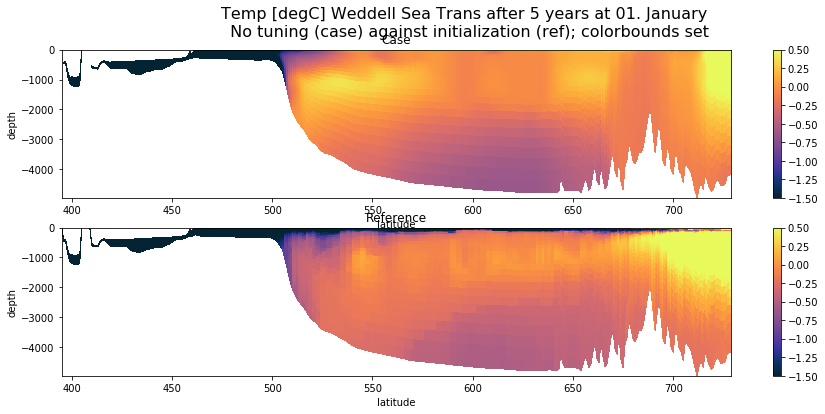

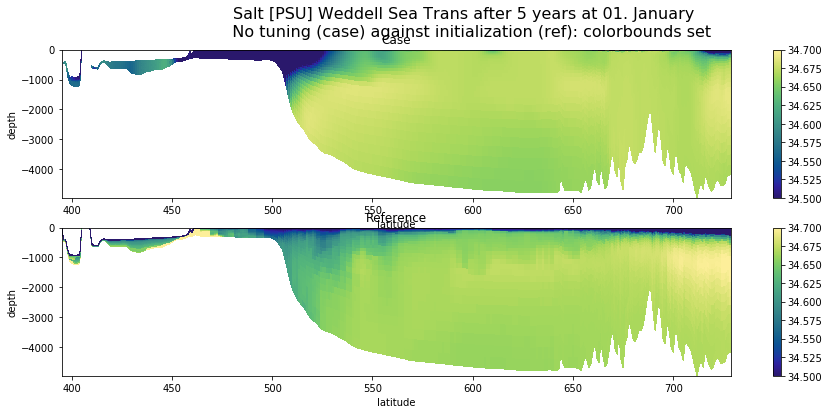

In [6]:
compare_trans(ref.temp[-1,:,395:,320],ini.temp[0,:,395:,320],
            'Temp [degC] Weddell Sea Trans after 5 years at 01. January \n No tuning (case) against initialization (ref); colorbounds set',
            -1.5,0.5,cmap=cmo.thermal)
compare_trans(ref.salt[-1,:,395:,320],ini.salt[0,:,395:,320],
            'Salt [PSU] Weddell Sea Trans after 5 years at 01. January \n  No tuning (case) against initialization (ref): colorbounds set',
            34.5,34.7,cmap=cmo.haline)

* The surface layer gets eroded,
* the simulation shows fully mixed water column over rough topography
* and mixed sections in the upper 2000m where topo is flat.
## SST and SSS, 1. January snapshot compared against initial values

In [7]:
def print_maxMin(case_da,ref_da,title_str):
    print(title_str)
    print('Case: %.2f %.2f'
          %(case_da.max().values,case_da.min().values),
          ' || refrence: %.2f %.2f' %(ref_da.max().values,ref_da.min().values))

In [8]:
print_maxMin(ref.temp[-1,30],ini.temp[0,30].where(ref.mask_rho),'Max\Min Surface Temp values [degC]: No tuning (case) vs. initial (ref)')
print_maxMin(ref.salt[-1,30],ini.salt[0,30].where(ref.mask_rho),'Max\Min Surface Salt values [PSU]: No tuning (case) vs. initial (ref)')

Max\Min Surface Temp values [degC]: No tuning (case) vs. initial (ref)
Case: 111.45 -11.05  || refrence: 10.00 -2.64
Max\Min Surface Salt values [PSU]: No tuning (case) vs. initial (ref)
Case: 34.98 19.77  || refrence: 34.80 33.20


* Roms produces an order of magnitude to high surface tempertures and about 8 degree to cold ones.
* Upper values of surface salinity look good, but roms gets to fresh at the surface by about 10 PSU. 

In [9]:
def compare_SSX(case_da,ref_da,vmin=None,vmax=None,title_str=None,cmap=None):
    plt.close()
    fig,axes = plt.subplots(ncols=2,figsize=(15,4))
    fig.suptitle(title_str)
    case_da.plot(ax=axes[0],vmin=vmin,vmax=vmax,cmap=cmap)
    ref_da.plot(ax=axes[1],vmin=vmin,vmax=vmax,cmap=cmap)
    for ax in axes:
        ax.set_aspect('equal')
    plt.show()

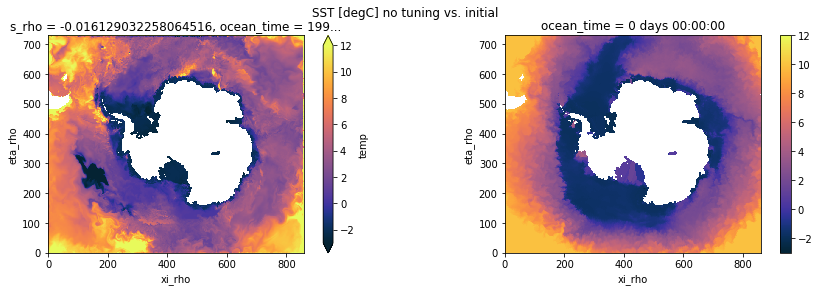

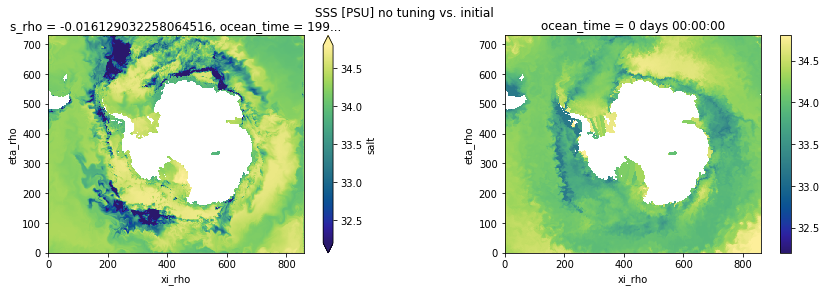

In [10]:
compare_SSX(ref.temp[-1,30],ini.temp[0,30].where(ref.mask_rho),-3,12,'SST [degC] no tuning vs. initial',cmap=cmo.thermal)
compare_SSX(ref.salt[-1,30],ini.salt[-0,30].where(ref.mask_rho),32.2,34.8,'SSS [PSU] no tuning vs. initial',cmap=cmo.haline)

* WAOM shows a lot more spatial variablity than ECCO.
* with local patches of high and low temperature and salinity.

# Effect of QCORRECTION
In summer (Nov, Dec, Jan, Feb; Takeshi melt season) we relax surface net heat flux to SOSE SST with a sensitifity of -40 W/m^2/K (more or less random, order of magnitude from Barnier 1995).

In [11]:
#load and setup roms_data
QCOR_path = os.path.join(os.environ.get('rawdir'),'waom10_QCORRECT','ocean_his_noSOF_0005.nc')
QCOR = roms_ds.make_roms_ds(QCOR_path)

set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


## SST and SSS, 1. January QCOR vs. no tuning

In [12]:
print_maxMin(QCOR.temp[-1,30],ini.temp[0,30].where(ref.mask_rho),'Max\Min Temp values [degC]: QCOR (case) vs. no tuning (ref)')

Max\Min Temp values [degC]: QCOR (case) vs. no tuning (ref)
Case: 17.52 -3.41  || refrence: 10.00 -2.64


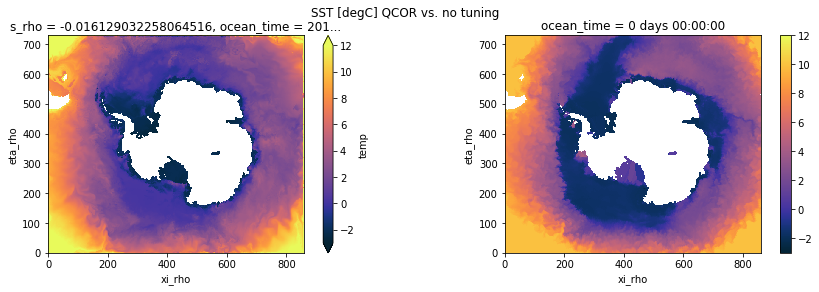

In [13]:
compare_SSX(QCOR.temp[-1,30],ini.temp[0,30].where(ref.mask_rho),-3,12,'SST [degC] QCOR vs. no tuning',cmap=cmo.thermal)

* that looks a lot better, peak values of temperatures are just slightly off at the surface anymore
* however, we lost a good deal of TAMURA variablity and SST seems to be to warm around the coast and far north.

# Effect of QCORRECT and QSOF
In addition to QCORRECTION we added a heat surface overflux fix (QSOF) that does the following:
If sst goes below the freezing point, surface net heat flux is relaxed towards the freezing point

In [14]:
#load and setup roms_data
QSOF_path = os.path.join(os.environ.get('rawdir'),'waom10_QCORRECT','ocean_his_0005.nc')
QSOF = roms_ds.make_roms_ds(QSOF_path)

set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


## SST, July QCOR+QSOF vs. QCOR

In [15]:
print_maxMin(QSOF.temp[6,30],QCOR.temp[6,30],'Max\Min Temp values [degC]: QSOF+QCOR (case) vs. QCOR (ref)')

Max\Min Temp values [degC]: QSOF+QCOR (case) vs. QCOR (ref)
Case: 12.44 -3.73  || refrence: 12.45 -18.58


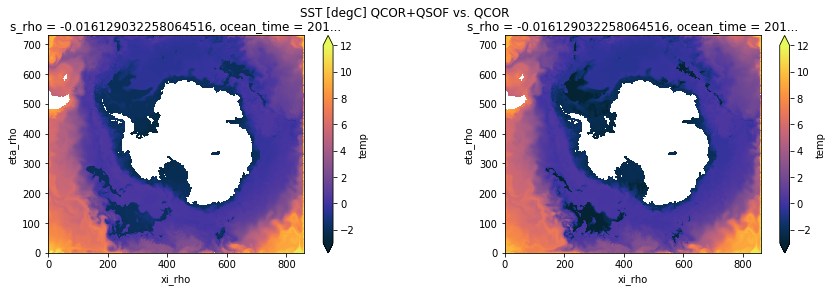

In [16]:
compare_SSX(QSOF.temp[6,30],QCOR.temp[6,30],-3,12,'SST [degC] QCOR+QSOF vs. QCOR',cmap=cmo.thermal)

# The effect of SCORRECTION
In addition to the other heat flux corrections Sea surface salt flux gets relaxed to SSS from SOSE. The relaxation time scale is 30 days and the the nudging happens all year round.  

In [17]:
#load and setup roms_data
SCOR_path = os.path.join(os.environ.get('rawdir'),'waom10_SCORRECT','ocean_his_lowNudge_swfBug_noSOF_0005.nc')
SCOR = roms_ds.make_roms_ds(SCOR_path)

set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


## SSS 1. January SCOR vs. ref

In [18]:
print_maxMin(SCOR.salt[-1,30],ref.salt[-1,30],'Max\Min Salt values [PSU]: SCOR+QCOR+QSOF (case) vs. no tuning (ref)')

Max\Min Salt values [PSU]: SCOR+QCOR+QSOF (case) vs. no tuning (ref)
Case: 34.80 16.74  || refrence: 34.98 19.77


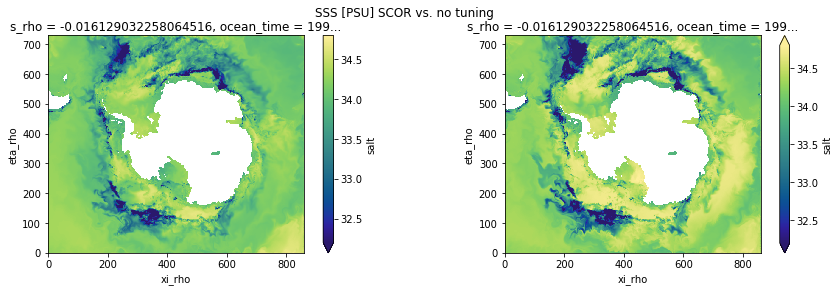

In [19]:
compare_SSX(SCOR.salt[-1,30],ref.salt[-1,30],32.2,34.8,'SSS [PSU] SCOR vs. no tuning',cmap=cmo.haline)

* the lower limit is even fresher than before?
* we lost a good deal of spacial variablity.

## Weddell Sea transect, Januar snapshot, SCOR vs. no tuning

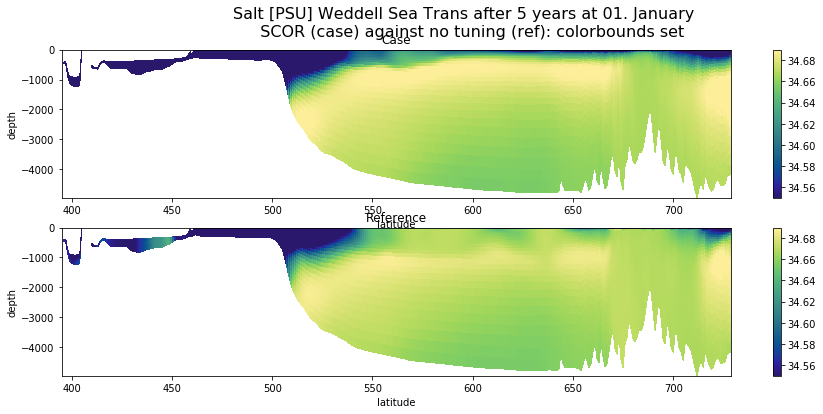

In [20]:
compare_trans(SCOR.salt[0,:,395:,320],ref.salt[0,:,395:,320],
            'Salt [PSU] Weddell Sea Trans after 5 years at 01. January \n  SCOR (case) against no tuning (ref): colorbounds set',
            34.55,34.69,cmap=cmo.haline)

* we have a surface layer now
* the water column over flat topo looks quite stable
* even the mixing over rough topo is less and the water column more stratified than before

# The effect of SCORRECTION and SSOF
In addition to the SCORRECTION we added an salt surface overflux fix (SSOF) which does the following:
Salt flux is set to zero if the ocean loses heat (winter), but is not close to the freezing point.
This was implemented to avoid salt input in warm water (Takeshi says its a polynya, but roms is not yet at freezing point).
CAUTION, this will most likey mess up Takeshis annual salt balance. Maybe the ocean is freshening in longer integrations now, however maybe SOSE flux correction will balance this.  

In [21]:
#load and setup roms_data
SSOF_path = os.path.join(os.environ.get('rawdir'),'waom10_SCORRECT','ocean_his_lowNudge_swfBug_0005.nc')
SSOF = roms_ds.make_roms_ds(SSOF_path)

set up multifile dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


## SSS March SCOR+SSOF vs. SCOR

In [22]:
print_maxMin(SSOF.salt[2,30],SCOR.salt[2,30],'Max\Min Temp and Salt values: SCOR+SSOF (case) vs. SCOR (ref)')

Max\Min Temp and Salt values: SCOR+SSOF (case) vs. SCOR (ref)
Case: 34.80 15.98  || refrence: 34.80 15.97


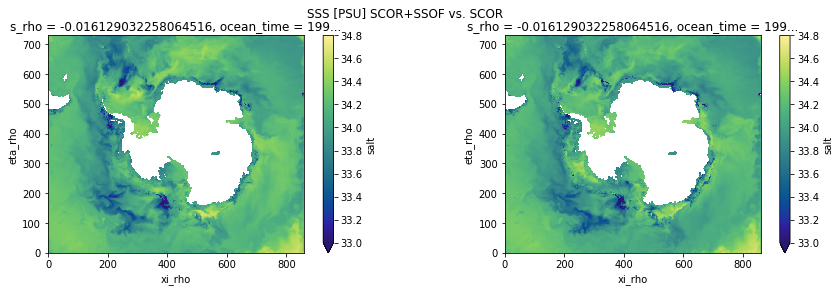

In [23]:
compare_SSX(SSOF.salt[2,30],SCOR.salt[2,30],33.0,34.8,'SSS [PSU] SCOR+SSOF vs. SCOR',cmap=cmo.haline)

* seems to have no big impact

## Weddell Sea transect, 1. Januar snapshot, SCOR+SSOF vsSCOR

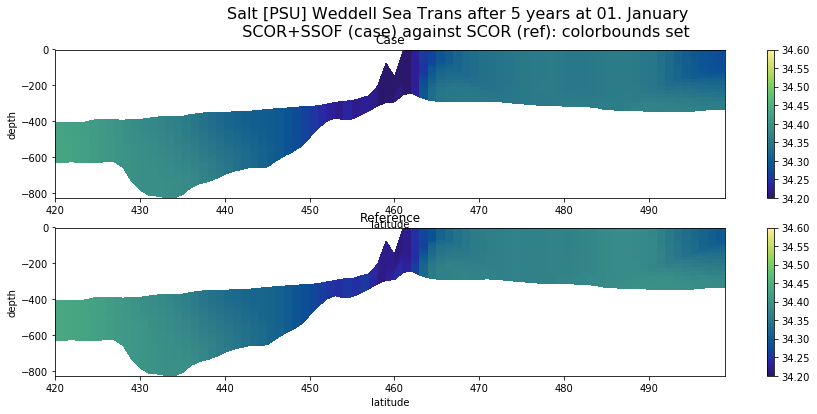

In [24]:
compare_trans(SSOF.salt[2,:,420:500,320],SCOR.salt[2,:,420:500,320],
            'Salt [PSU] Weddell Sea Trans after 5 years at 01. January \n  SCOR+SSOF (case) against SCOR (ref): colorbounds set',
            34.2,34.6,cmap=cmo.haline)

* in sea ice regions a bit fresher?

In [25]:
print('Annual surface salt flux budget')
print('SCOR: %.2f' %SCOR.ssflux.sum(dim=['ocean_time','eta_rho','xi_rho']).values)
print('SSOF: %.2f' %SSOF.ssflux.sum(dim=['ocean_time','eta_rho','xi_rho']).values)

Annual surface salt flux budget
SCOR: -1.88
SSOF: -1.87


* SSOF does not seem to mess up the salt budget to much.